# Lab One: Exploring Table Data
Team: Jack Babcock, Hayden Center, Fidelia Navar, Amory Weinzierl

### Assignment Description
You are to perform preprocessing and exploratory analysis of a data set: exploring the statistical summaries of the features, visualizing the attributes, and addressing data quality. This report is worth 10% of the final grade. Please upload a report (one per team) with all code used, visualizations, and text in a rendered Jupyter notebook. Any visualizations that cannot be embedded in the notebook, please provide screenshots of the output.

Additional information and requirements can be found at https://smu.instructure.com/courses/81978/assignments/465788

## Part I -  Business Understanding

The data set (which can be found at https://www.kaggle.com/fedesoriano/stroke-prediction-dataset) that we have chosen to utilize for this lab consists of data that may be used to identify whether or not an individual is at risk for strokes.<br><br>
This data was likely collected by medical professionals in a medical trial with the goal of recognizing what attributes may contribute to the likelihood of a stroke in an individual. We may speculate that this was the given circumstances the data was collected under (although not explicitly said) because medical records are not publicly available and, thus, the patients involved would have had to have been aware that the data would be used for a study. Further, we can safely assume that the data was collected by medical professionals because they know what sort of attributes would be pertinent to increasing the chance of a stroke and it is in their interest to conduct studies of this sort to further their knowledge about such medical happenings.<br><br>
Given the attributes of the individuals involved in this dataset, ideally it would be possible to predict whether an individual is at heightened risk for strokes. This functionality would be valuable to third parties in the medical industry; an accurate diagnoses done with training and classification may remove the possibility of human error in false diagnoses or lack of diagnoses. Furthermore, I think this functionality may also be useful to general users; of course, an app should never replace a medical professional but, if an individual is health-conscious and deemed at high risk for strokes, an app may be helpful to keep track of changing statistics on an individual basis and how that may affect an individual's risk of stroke. For example, if an individual's BMI decreases or increases, an individual may put that change into the app and see how that may affect their risk.<br><br>
Quite simply, our prediction algorithm would need to perform better than its competitors. Performing better may be defined as less false positives and negatives. According to "Positive predictive value of stroke identification by ambulance clinicians in North East England: a service evaluation," 38% of diagnosed strokes between June 2013 and May 2016 were false positives. In 2012, the Dijon Stroke Registry identified 811 patients with a stroke, among who 186 were considered false-negatives. Further, of the 903 patients discharged following a stroke, 278 were found to be false positives (https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3566387/). As given in the preceding data, 23% of diagnosed strokes were false negatives and 31% of diagnosed strokes were false positives. Thus, our algorithm must be more accurate than the calculated percentage of false negatives and false positives to be considered more useful than at least human diagnoses. In terms of performing better than competing instruments, our algorithm must report better than 85% - 90% sensitivity (https://pubmed.ncbi.nlm.nih.gov/17678494/).<br><br>
Additional details to consider and implement in our algorithm may be characteristics of common misdiagnoses. According to the article "Stroke misdiagnosis -- why does it still happen," the misdiognosis of strokes is the most common medical negligence issue encountered by the sponsor of the article (https://www.browells.co.uk/stroke-misdiagnosis-still-happen/). For example, in younger patients, strokes are commonly misdiagnosed as false negatives where it is thought that the issue is veritgo or alcohol intoxication (https://journals.lww.com/neurotodayonline/fulltext/2009/04020/younger_stroke_patients_often_misdiagnosed.8.aspx). Thus, our algorithm must address these common misdiagnosis. It may do so by factoring in extra information to report if an individual is at high risk for misdiagnoses.

## Part II - Data Understanding

### Data Description

#### Importing

In [11]:
import numpy as np
import pandas as pd

print('Pandas:', pd.__version__)
print('Numpy:',  np.__version__)

df = pd.read_csv('healthcare-dataset-stroke-data.csv')

df.head()

Pandas: 1.1.0
Numpy: 1.20.1


,id,gender,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


#### Formatting

To clean up the data a little bit, we're going to normalize the values of the non-numeric columns to have the same format by setting all values to lowercase and replacing spaces with underscores.

In [12]:
for c in df.columns:
    if df[c].dtype == 'object':
        df[c] = df[c].str.lower()
        
df = df.replace(' ', '_', regex=True)
        
for c in df.columns:
    if df[c].dtype == 'object':
        print(df[c].unique())

['male' 'female' 'other']
['yes' 'no']
['private' 'self-employed' 'govt_job' 'children' 'never_worked']
['urban' 'rural']
['formerly_smoked' 'never_smoked' 'smokes' 'unknown']


All of the columns look good except for the smoking_status column. One of the values in that column is listed as 'unknown'. Though this is technically a value, what it is actually representing is missing information, so let's make that more clear.

In [13]:
df.smoking_status.mask(df.smoking_status == 'unknown', pd.NA, inplace=True)

print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     3566 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB
None


Some of the categorical columns should be converted into numerical columns. Specifically the ever_married column should be converted into a binary column similar to the hypertension, heart_disease, and stroke columns, and the smoking_status column should be converted into an ordinal. We think this is a meaningful change because there is a very clear way to assign an order to the values: never_smoked is 0, formerly_smoked is 1 since it is worse for your health, and finally smokes is 2, since it is worse than formerly_smoked.

In [14]:
df.smoking_status.replace(to_replace= ['never_smoked', 'formerly_smoked', 'smokes'], value = [0, 1, 2], inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     3566 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


### Data Quality

#### Duplicate Values

The first thing we'll want to do to check the quality of the data is to check for duplicates. First, let's make sure there are no duplicate IDs in the dataset.

In [15]:
if df.id.unique().size == df.id.size:
    print("No duplicate IDs")

No duplicate IDs


Now that we know there are no duplicate IDs, let's check if there are any rows with identical values (excluding the ID).

In [16]:
cols = df.columns.drop('id')

s = df.duplicated(subset=cols, keep='first')

s[s]

Series([], dtype: bool)

Seems like the dataset has no exact duplicates. We feel safe assuming that, finding no exact duplicates, each entry in the dataset is unique.

#### Missing Values

The second thing to check the dataset for is missing values. We can see them by checking df.info().

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     3566 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


Now we can see how much data is really missing from this dataset. We have over 1500 missing datapoints from the smoking_status column. Now let's take a look at both of the columns with missing data and see if we want to impute or delete them.

In [18]:
from sklearn.impute import KNNImputer
import copy

knn = KNNImputer(n_neighbors=3)

temp = df[[
    'age',
    'hypertension',
    'heart_disease',
    'avg_glucose_level',
    'bmi',
    'stroke'
]].to_numpy()

temp_imputed = knn.fit_transform(temp)

df_imputed = copy.deepcopy(df)
df_imputed[[
    'age',
    'hypertension',
    'heart_disease',
    'avg_glucose_level',
    'bmi',
    'stroke'
]] = temp_imputed
# df_imputed.info()

df_imputed.bmi = df_imputed.bmi.apply(lambda x: round(x, 1))

print(df_imputed.count())

id                   5110
gender               5110
age                  5110
hypertension         5110
heart_disease        5110
ever_married         5110
work_type            5110
residence_type       5110
avg_glucose_level    5110
bmi                  5110
smoking_status       3566
stroke               5110
dtype: int64


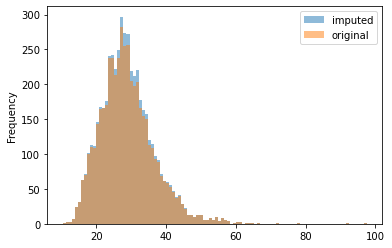

In [19]:
import matplotlib
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter('ignore', DeprecationWarning)
%matplotlib inline 

df_imputed.bmi.plot(kind='hist', alpha=0.5, label="imputed",bins=100)
df.bmi.plot(kind='hist', alpha=0.5, label="original",bins=100)
plt.legend()
plt.show()

## Part III - Data Visualization

hypertension              False      True 
gender ever_married                       
female no             96.777442   3.222558
       yes            87.806097  12.193903
male   no             97.247706   2.752294
       yes            85.133136  14.866864
other  no            100.000000   0.000000

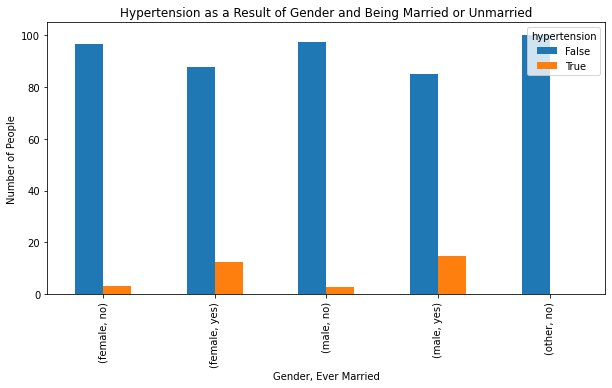

heart_disease             False      True 
gender ever_married                       
female no             98.288016   1.711984
       yes            95.202399   4.797601
male   no             98.034076   1.965924
       yes            89.053254  10.946746
other  no            100.000000   0.000000

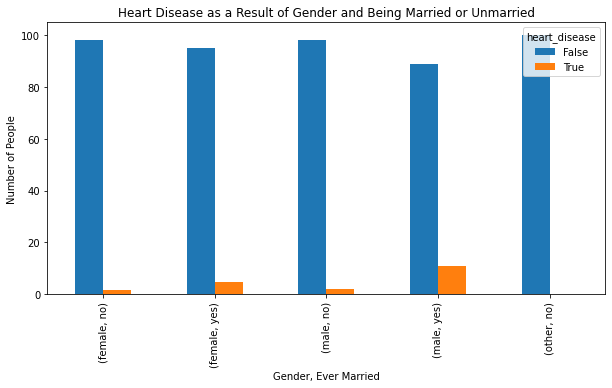

stroke                    False     True 
gender ever_married                      
female no             97.885196  2.114804
       yes            94.002999  5.997001
male   no             98.951507  1.048493
       yes            92.603550  7.396450
other  no            100.000000  0.000000

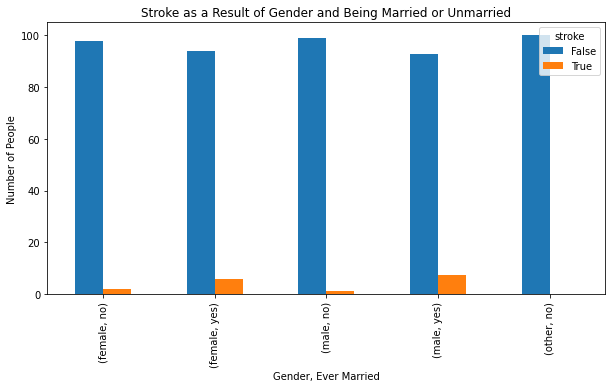

In [44]:
#https://matplotlib.org/3.1.1/gallery/lines_bars_and_markers/barchart.html
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

hyper = pd.crosstab([df_imputed['gender'], df_imputed['ever_married']], df_imputed.hypertension.astype(bool)).apply(lambda r: r/r.sum()*100, axis=1)
hyper_ = hyper.plot.bar(figsize=(10,5),stacked=False)
display(hyper)

plt.title('Hypertension as a Result of Gender and Being Married or Unmarried')
plt.xlabel('Gender, Ever Married')
plt.ylabel('Number of People')
plt.show()

heart= pd.crosstab([df_imputed['gender'], df_imputed['ever_married']], df_imputed.heart_disease.astype(bool)).apply(lambda r: r/r.sum()*100, axis=1)
heart_ = heart.plot.bar(figsize=(10,5),stacked=False)
display(heart)

plt.title('Heart Disease as a Result of Gender and Being Married or Unmarried')
plt.xlabel('Gender, Ever Married')
plt.ylabel('Number of People')
plt.show()

gender = pd.crosstab([df_imputed['gender'], df_imputed['ever_married']], df_imputed.stroke.astype(bool)).apply(lambda r: r/r.sum()*100, axis=1)
gender_ = gender.plot.bar(figsize=(10,5),stacked=False)
display(gender)

plt.title('Stroke as a Result of Gender and Being Married or Unmarried')
plt.xlabel('Gender, Ever Married')
plt.ylabel('Number of People')
plt.show()

for rec in ax_.patches:
    height = rec.get_height()
    ax_.text(rec.get_x() + rec.get_width() / 2, 
              rec.get_y() + height / 2,
              "{:.0f}%".format(height),
              ha='center', 
              va='bottom')

## Part IV - Exceptional Work